%matplotlib inline
#Imports required to run

import pynbody
SimArray = pynbody.array.SimArray
from matplotlib.pylab import *
import matplotlib.pylab as plt
import pynbody.plot.sph as sph
import numpy as np
from scipy import interpolate

#Tell code where my diskpy distribution is
import os

#Import diskpy and my modules from ICgen submodule
import diskpy
from diskpy.ICgen import *
from diskplot import *

from __future__ import division

#Typical plot parameters that make for pretty plots
plt.rcParams['figure.figsize'] = (10,8)
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=20, usetex=True)

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rcParams['font.size'] = 20.0

In [2]:
cwd = '/astro/users/dflemin3/Desktop/sims/k38_e_0.1032_final'
os.chdir(cwd)

# Number of bins
bins = 75

In [3]:
#Read in .param file and extract info I need

name = ''
length = 0
dDelta = 0.0

#Find param file if it exists
for file in os.listdir(cwd):
    if file.endswith(".param"):
        filename = file
        break
    else:
        filename = "Invalid"
        
#No file name so give warning before program dies
if filename == "Invalid":
    print "No .param file found!"

else:
    with open(filename) as f:
        lines = f.readlines()

    #Iterate over lines in param file, look for ones of interest
    for line in lines:
        line = str(line).rstrip('\n')

        #.param files are of the form: tParamName = val
        
        #Look for file name
        if "achOutName" in line:
             name = line.split()[-1]

        #Look for iOutInterval
        if "iOutInterval" in line:
            outInt = int(line.split()[-1])

        #Look for number of steps
        if "nSteps" in line:
            nSteps = int(line.split()[-1])

        #Look for dDelta
        if "dDelta" in line:
            dDelta = float(line.split()[-1])
            
#Compute important quantities
length = int(nSteps/outInt)
dt = dDelta/(2.0*np.pi) #Years per step

In [4]:
#Calculate system parameters
s = pynbody.load(name + ".119000")
#Center on barycenter
diskCom = binaryUtils.computeCOM(s.stars,s.gas,starFlag=True,gasFlag=True)
s['pos'] -= diskCom

x1, x2 = s.stars['pos']
m1, m2 = s.stars[0]['mass'], s.stars[1]['mass']
v1, v2 = s.stars['vel']
m_disk = np.sum(s.gas['mass'])
x = x1-x2
v = v1-v2
X = [x,v]
test = binary.Binary(X,m1,m2,'cartesian')
print test

(0.137936026426,[ 0.14566849],0.000560101541023,99.4261844526,300.294312405,161.274460418), mass: ([ 0.94901174],[ 0.24920164])


In [5]:
x1_gas = s.gas['pos']
x_zero = pynbody.array.SimArray(np.zeros((len(x1_gas),3)),'au')
v1_gas = s.gas['vel']
v_zero = pynbody.array.SimArray(np.zeros((len(x1_gas),3)),'km s**-1')
m1 = np.sum(s.s['mass'])
m2 = s.gas['mass']
gas_m = s.gas['mass'].in_units('g')

cm = binaryUtils.computeCOM(s.stars,s.gas,cutoff=3.0).in_units('au')

#Compute semimajor axis, longitude of perihelion (relative to that of bin) for ALL gas particles
gas_a = AddBinary.calcSemi(x1_gas,cm,v1_gas,v_zero,m1,m2)
gas_e = AddBinary.calcEcc(x1_gas,cm,v1_gas,v_zero,m1,m2)
gas_i = AddBinary.calcInc(x1_gas,cm,v1_gas,v_zero)
gas_w = AddBinary.calcArgPeri(x1_gas,cm,v1_gas,v_zero,m1,m2) + AddBinary.calcLongOfAscNode(x1_gas,x_zero,v1_gas,v_zero)
gas_w = gas_w - (test.Omega + test.w)

gas_theta = SimArray(np.arctan2(s.gas['y'],s.gas['x']),'1')

v_theta = ((s.gas['x'] * s.gas['vy'] - s.gas['y'] * s.gas['vx']) / s.gas['rxy']).in_units('km s**-1')
v_r  = ((s.gas['pos'][:, 0:2] * s.gas['vel'][:, 0:2]).sum(axis=1) / s.gas['rxy']).in_units('km s**-1')

while np.sum(gas_w > 360) > 0:
    gas_w[gas_w > 360] = gas_w[gas_w > 360] - 360.0

while np.sum(gas_w < 0) > 0:    
    gas_w[gas_w < 0] = gas_w[gas_w < 0] + 360.0

inner = 0
outer = 3

x_min = 0
x_max = 360
y_min = inner
y_max = outer
extent = [[x_min,x_max],[y_min,y_max]]

#Filter out gas particles that aren't bound
mask = np.logical_and(gas_e < 1,gas_e > 0)
gas_a = gas_a[mask]
gas_w = gas_w[mask]
gas_e = gas_e[mask]
gas_m = gas_m[mask]
gas_theta = gas_theta[mask]
gas_i = gas_i[mask]
v_theta = v_theta[mask]
v_r = v_r[mask]

#Now Filter gas particles to within a certain distance
mask = np.logical_and(gas_a < outer,gas_a > inner)
gas_a = gas_a[mask]
gas_w = gas_w[mask]
gas_e = gas_e[mask]
gas_m = gas_m[mask]
gas_theta = gas_theta[mask]
gas_i = SimArray(gas_i[mask],'1.0')
v_theta = v_theta[mask]
v_r = v_r[mask]

/astro/apps6/anaconda2.0/lib/python2.7/site-packages/matplotlib/axes/_base.py:1209: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/astro/apps6/anaconda2.0/lib/python2.7/site-packages/matplotlib/axes/_base.py:1214: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


(<matplotlib.axes._subplots.AxesSubplot at 0x7f6ef5c70650>,
 <matplotlib.colorbar.Colorbar at 0x7f6ebbfda7d0>)

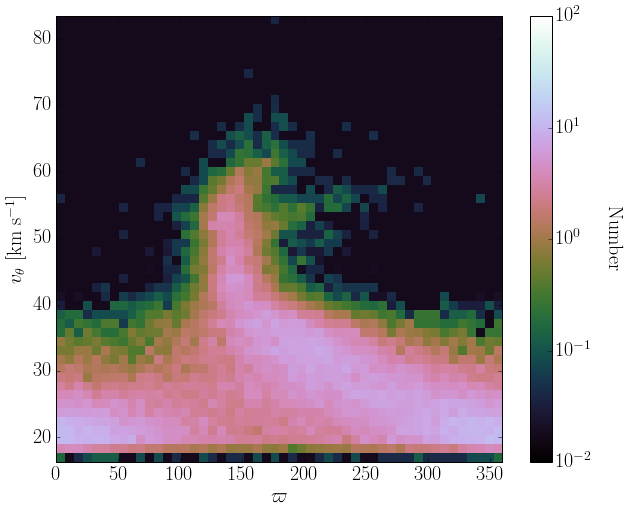

In [6]:
diskplot.plot_heatmap(gas_w,v_theta,labels=[r'$\varpi$',r'$v_{\theta}$ [km s$^{-1}$]','Number'],cm='cubehelix',
                      norm='log',avg='x',vmax=1.0e2,vmin=1.0e-2)

/astro/users/dflemin3/.local/lib/python2.7/site-packages/diskplot/diskplot.py:215: RuntimeWarning: invalid value encountered in divide
  H /= tmp_mean


(0, 3)

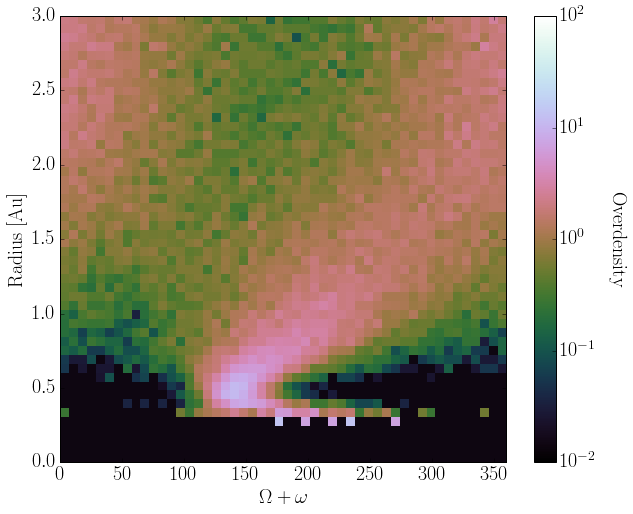

In [7]:
x_min = 0
x_max = 360
y_min = 0
y_max = 3
extent = [[x_min,x_max],[y_min,y_max]]

ax, im, cbar = diskplot.plot_heatmap(gas_w,gas_a,labels=['$\Omega + \omega$','Radius [Au]','Overdensity'],
                                    cm='cubehelix',norm='log',avg='y',vmax=1.0e2,vmin=1.0e-2,hist_range=extent)

# Ensure plots are same dimensions
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)

SimArray([[-0.13110314, -0.13321321, -0.13532326, ..., -0.296987  ,
        -0.28931382, -0.28164065],
       [-0.12544656, -0.12818323, -0.13091989, ..., -0.29502776,
        -0.28708297, -0.27913815],
       [-0.11978996, -0.12315325, -0.12651652, ..., -0.29306853,
        -0.28485212, -0.27663571],
       ..., 
       [ 0.38929638,  0.37676176,  0.36422721, ..., -0.10492741,
        -0.11301177, -0.12109612],
       [ 0.38884056,  0.3759948 ,  0.36314905, ..., -0.10752191,
        -0.1158096 , -0.12409732],
       [ 0.38838476,  0.37522781,  0.36207092, ..., -0.11011641,
        -0.11860744, -0.12709847]], dtype=float32, 'km s**-1')

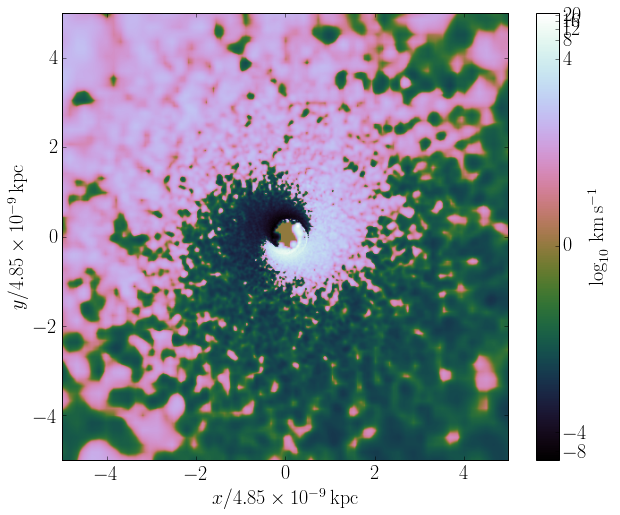

In [9]:
pynbody.plot.sph.image(s.gas, qty='vrxy', units='km s**-1', width="10 au",
                       cmap='cubehelix',log=True)

# Make a movie of [quantity] over time

In [5]:
time = np.zeros(length-1)
angle = np.zeros(length-1)

In [6]:
%%capture 
for i in range(1,length):
    suffix = str(i*outInt).zfill(6)
    snap_name = name + "." + suffix
    s = pynbody.load(snap_name)
    
    #Center on barycenter
    diskCom = binaryUtils.computeCOM(s.stars,s.gas,starFlag=True,gasFlag=True)
    s['pos'] -= diskCom
    
    pynbody.plot.sph.image(s.gas, qty='vrxy', width="10 au",cmap='RdYlBu',log=False,vmin=-0.05,vmax=0.05,linthresh=0.001)
    
    #Save fig for future movie
    fig_name = "wave." + str(i) + ".jpeg"
    plt.savefig(fig_name)
    plt.clf()